In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')



In [2]:
df=pd.read_csv('Merged.csv')

print(df.shape)
df.head()


(49750, 2)


,url,type
0,br-icloud.com.br,phishing
1,http://www.garage-pirenne.be/index.php?option=...,defacement
2,http://adventure-nicaragua.net/index.php?optio...,defacement
3,http://www.pashminaonline.com/pure-pashminas,defacement
4,http://www.ikenmijnkunst.nl/index.php/expositi...,defacement


In [3]:
df.type.value_counts()

type
benign        36419
defacement     9158
phishing       3002
malware        1171
Name: count, dtype: int64

In [4]:
# Quick data quality check
print(df.info())
print(df.isnull().sum())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49750 entries, 0 to 49749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     49750 non-null  object
 1   type    49750 non-null  object
dtypes: object(2)
memory usage: 777.5+ KB
None
url     0
type    0
dtype: int64
                                                      url    type
count                                               49750   49750
unique                                              47004       4
top     http://style.org.hc360.com/css/detail/mysite/s...  benign
freq                                                   15   36419


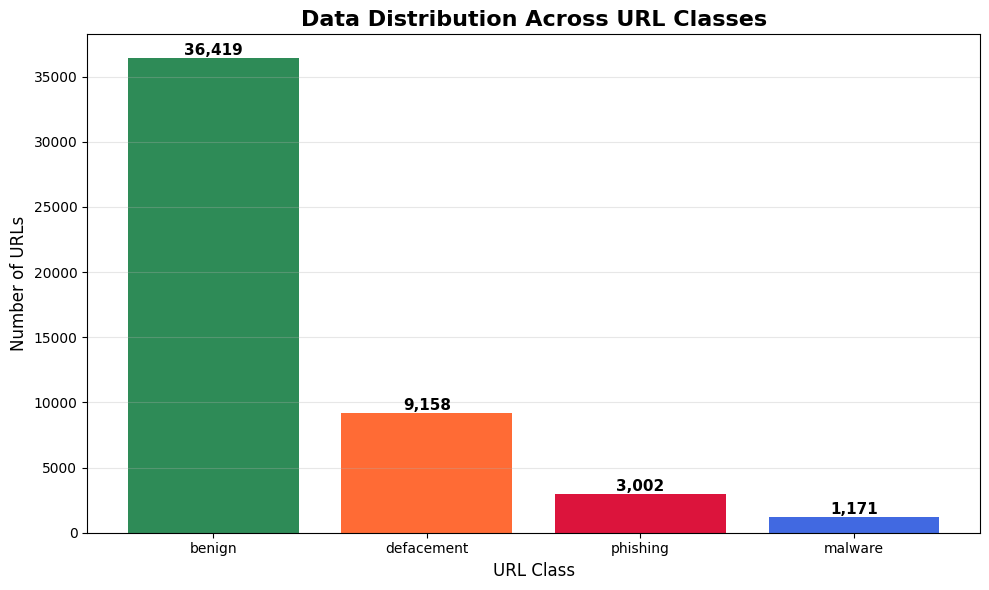

Class Distribution:
type
benign        36419
defacement     9158
phishing       3002
malware        1171
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt

# Get the class counts
class_counts = df.type.value_counts()

# Create a simple bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.index, class_counts.values, 
               color=['#2E8B57', '#FF6B35', '#DC143C', '#4169E1'])

# Add labels and title
plt.title('Data Distribution Across URL Classes', fontsize=16, fontweight='bold')
plt.xlabel('URL Class', fontsize=12)
plt.ylabel('Number of URLs', fontsize=12)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Rotate x-axis labels if needed
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print the class distribution
print("Class Distribution:")
print(class_counts)

In [6]:
# Duplicate check
print("Duplicate analysis:")
print(f"Total URLs: {len(df)}")
print(f"Unique URLs: {df['url'].nunique()}")
print(f"Duplicates: {len(df) - df['url'].nunique()}")

# See if duplicates have same labels
duplicates = df[df.duplicated('url', keep=False)]
print("\nDuplicate label consistency:")
print(duplicates.groupby('url')['type'].nunique().value_counts())

Duplicate analysis:
Total URLs: 49750
Unique URLs: 47004
Duplicates: 2746

Duplicate label consistency:
type
1    2506
Name: count, dtype: int64


In [7]:
# duplicate removal
df_clean = df.drop_duplicates(subset=['url'])
print(f"Dataset size: {len(df)} → {len(df_clean)}")

Dataset size: 49750 → 47004


In [8]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

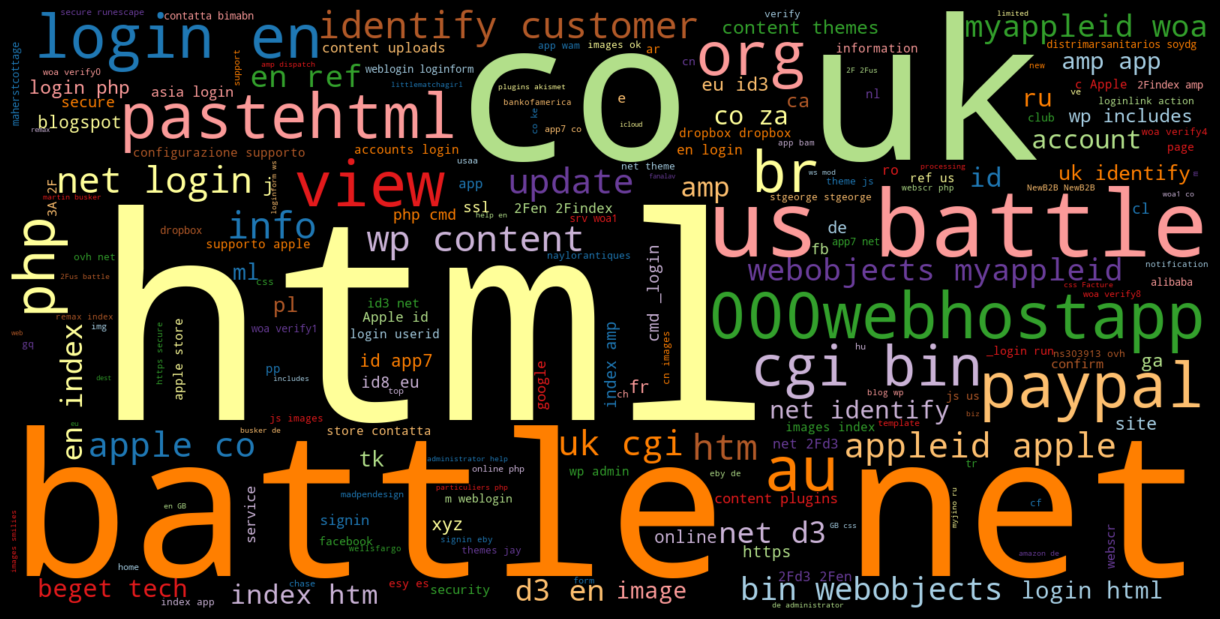

In [9]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

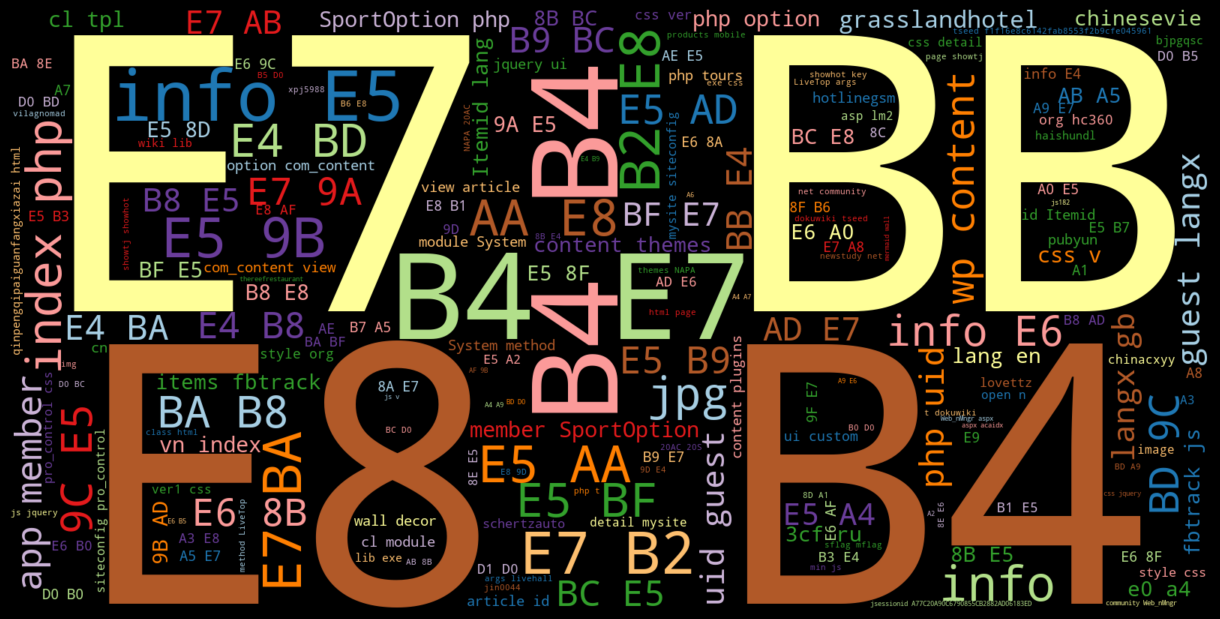

In [10]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

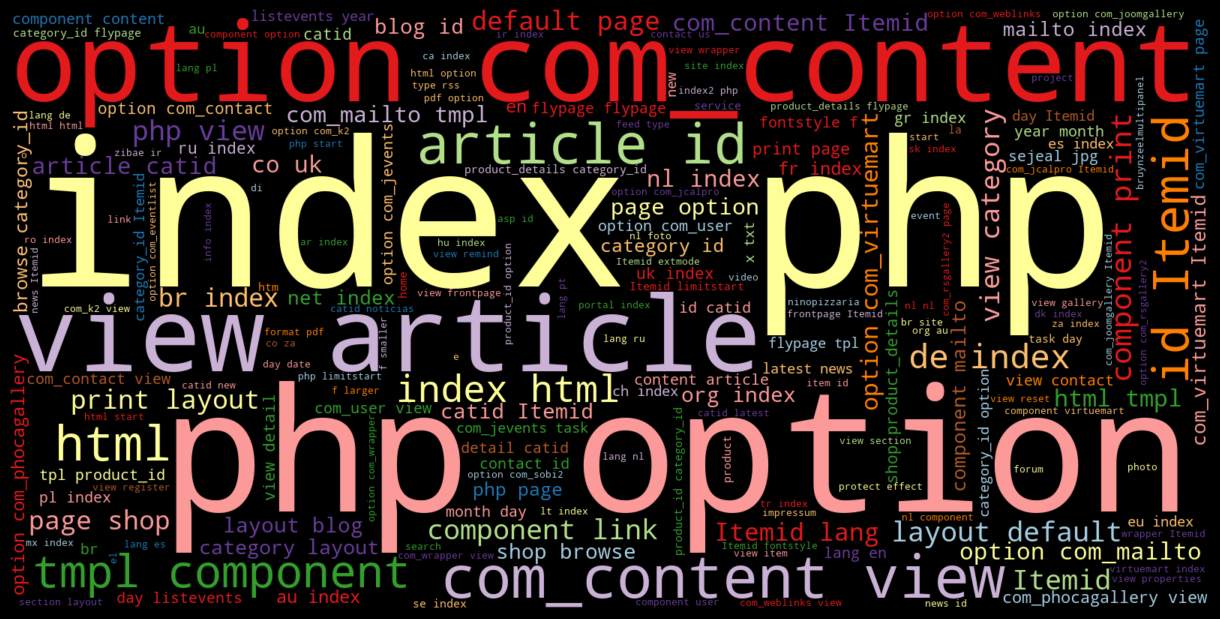

In [11]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

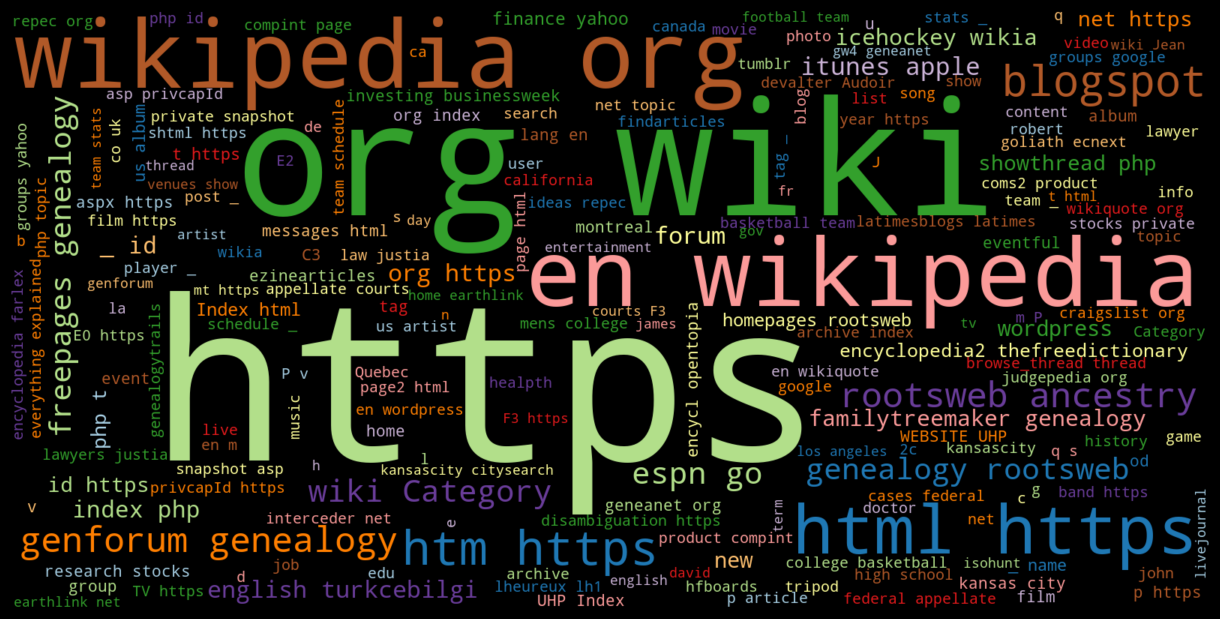

In [12]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [13]:
import re
def having_ip_address(u):
    u = (u or "").strip()
    if "://" not in u:   # add scheme if missing
        u = "http://" + u
    
    match = re.search(
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5]))|'
        r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2}))|'
        r'((?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4})',
        u
    )
    return 1 if match else 0

df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))


In [14]:
from urllib.parse import urlparse
def abnormal_url(u):
    u = (u or "").strip()
    if "://" not in u:   # ensure urlparse works
        u = "http://" + u

    hostname = urlparse(u).hostname or ""
    
    # If the hostname is present inside the URL → normal → return 0
    # If hostname is missing or mismatch → abnormal → return 1
    return 0 if hostname and hostname in u else 1

df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))


In [15]:
#!pip install googlesearch-python

In [16]:
#from googlesearch import search


In [17]:
#def google_index(url):
  #  site = search(url, 5)
  #  return 1 if site else 0
#df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [18]:
def count_dot(u):
    try:
        u = (u or "").strip()
        if "://" not in u:   # add scheme if missing
            u = "http://" + u
        hostname = urlparse(u).hostname or ""
        return hostname.count('.')
    except Exception:
        return 0

df['count_dot'] = df['url'].apply(count_dot)


df.head()

,url,type,use_of_ip,abnormal_url,count_dot
0,br-icloud.com.br,phishing,0,0,2
1,http://www.garage-pirenne.be/index.php?option=...,defacement,0,0,2
2,http://adventure-nicaragua.net/index.php?optio...,defacement,0,0,1
3,http://www.pashminaonline.com/pure-pashminas,defacement,0,0,2
4,http://www.ikenmijnkunst.nl/index.php/expositi...,defacement,0,0,2


In [19]:
def count_https(u):
    u = (u or "").lower()
    return u.count("https://")

def count_http(u):
    u = (u or "").lower()
    return 1 if "http://" in u and "https://" not in u else 0

df['count-https'] = df['url'].apply(count_https)
df['count-http'] = df['url'].apply(count_http)

In [20]:
def count_www(u):
    u = (u or "").lower()
    return u.count("www")

df['count-www'] = df['url'].apply(lambda i: count_www(i))


def count_atrate(u):
    u = (u or "")
    return u.count('@')

df['count@'] = df['url'].apply(count_atrate)


def no_of_dir(url):
    u = (url or "").strip()
    if "://" not in u:   # add scheme if missing
        u = "http://" + u
    urldir = urlparse(u).path or ""
    # normalize root slash → treat "/" same as ""
    if urldir == "/":
        urldir = ""
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    u = (url or "").strip()
    if not u:
        return 0
    if "://" not in u:
        u = "http://" + u
    try:
        parsed = urlparse(u)
        search_text = (parsed.path or "") + (parsed.query or "")
        domain_pattern = r'\b[a-zA-Z0-9-]+\.[a-zA-Z]{2,}\b'
        embedded_domains = re.findall(domain_pattern, search_text)
        return len(embedded_domains)
    except:
        return 0
df['count_embed_domain'] = df['url'].apply(lambda i: no_of_embed(i))

def shortening_service(u):
    u = (u or "").lower()
    match = re.search(
        r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
        r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
        r'short\.to|budurl\.com|ping\.fm|post\.ly|just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
        r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|lnkd\.in|'
        r'db\.tt|qr\.ae|adf\.ly|bitly\.com|cur\.lv|ity\.im|q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|'
        r'u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
        r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|tlurl\.com|'
        r'tweezer\.me|v\.gd|tr\.im|link\.zip\.net',
        u
    )
    return 1 if match else 0

df['short_url'] = df['url'].apply(shortening_service)


In [21]:
def count_per(u):
    u = (u or "")
    return u.count('%')

df['count%'] = df['url'].apply(count_per)


def count_ques(u):
    u = (u or "")
    return u.count('?')

df['count?'] = df['url'].apply(count_ques)

def count_hyphen(u):
    u = (u or "")
    return u.count('-')

df['count-'] = df['url'].apply(count_hyphen)


def count_equal(u):
    u = (u or "")
    return u.count('=')

df['count='] = df['url'].apply(count_equal)


def url_length(u):
    if not isinstance(u, str):
        return 0
    return len(u)

df['url_length'] = df['url'].apply(url_length)

def hostname_length(u):
    try:
        return len(urlparse(u).netloc)
    except:
        return 0

df['hostname_length'] = df['url'].apply(hostname_length)


df.head()

def suspicious_words(u):
    u = str(u or "")
    match = re.search(r'paypal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      u, re.IGNORECASE)
    return 1 if match else 0

df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(u):
    # Make sure input is a string (safe against None/NaN)
    u = str(u or "")
    # Count how many characters are digits
    return sum(c.isdigit() for c in u)

# Apply to your dataframe
df['count-digits'] = df['url'].apply(digit_count)


def letter_count(u):
    u = str(u or "")
    return sum(c.isalpha() for c in u)

df['count-letters'] = df['url'].apply(letter_count)

df.head()

,url,type,use_of_ip,abnormal_url,count_dot,count-https,count-http,count-www,count@,count_dir,...,short_url,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,http://www.garage-pirenne.be/index.php?option=...,defacement,0,0,2,0,1,1,0,1,...,0,0,1,1,4,88,21,0,7,63
2,http://adventure-nicaragua.net/index.php?optio...,defacement,0,0,1,0,1,0,0,1,...,0,0,1,1,3,200,23,0,18,168
3,http://www.pashminaonline.com/pure-pashminas,defacement,0,0,2,0,1,1,0,1,...,0,0,0,1,0,44,22,0,0,37
4,http://www.ikenmijnkunst.nl/index.php/expositi...,defacement,0,0,2,0,1,1,0,3,...,0,0,0,1,0,64,20,0,4,50


In [22]:
!pip install tld

In [24]:
# Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os

# --- First Directory Length ---
def fd_length(url):
    try:
        urlpath = urlparse(url).path
        parts = urlpath.split('/')
        if len(parts) > 1:
            return len(parts[1])   # length of first directory
        else:
            return 0   # no directory found
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

# --- Length of Top Level Domain ---
def tld_length(url):
    try:
        tld = get_tld(url, fail_silently=True)
        return len(tld) if tld else -1   
    except:
        return -1


df['tld_length'] = df['url'].apply(lambda i: tld_length(i))


In [25]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'count_dot', 'count-https',
       'count-http', 'count-www', 'count@', 'count_dir', 'count_embed_domain',
       'short_url', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'count-digits', 'count-letters',
       'fd_length', 'tld_length'],
      dtype='object')

In [26]:
df['type'].value_counts()

type
benign        36419
defacement     9158
phishing       3002
malware        1171
Name: count, dtype: int64

In [27]:
#df = df.drop("tld", axis=1)


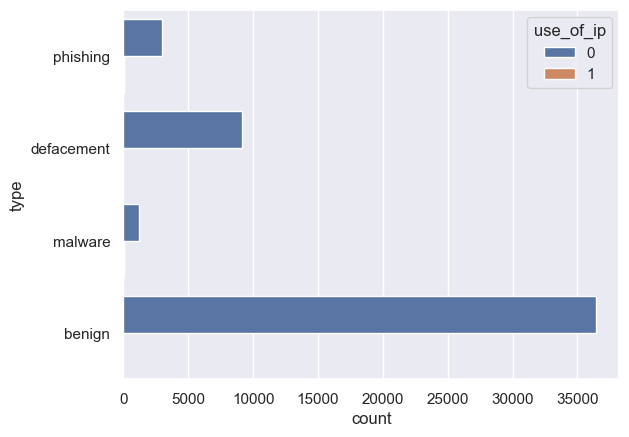

In [29]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

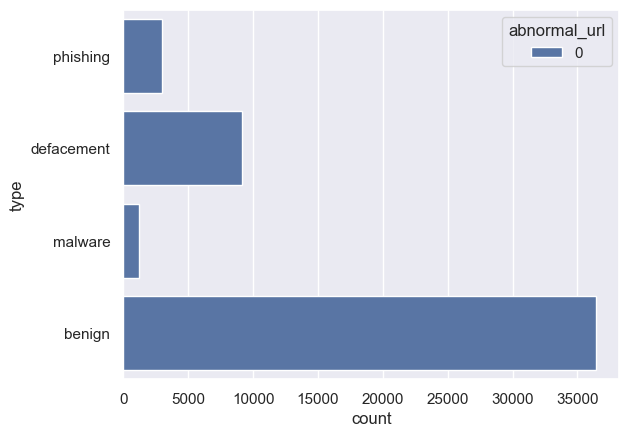

In [30]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

In [31]:
#sns.set(style="darkgrid")
#ax = sns.countplot(y="type", data=df,hue="google_index")

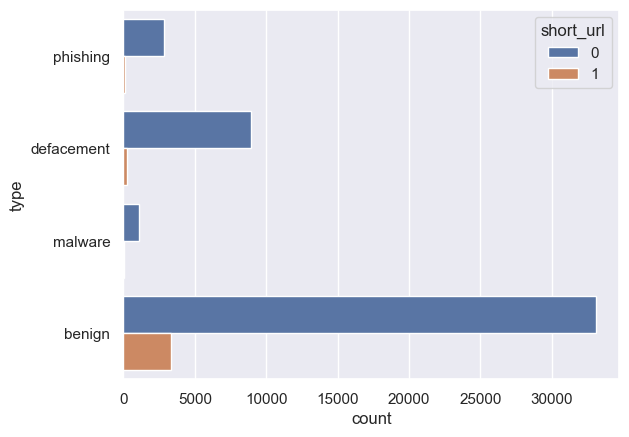

In [32]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

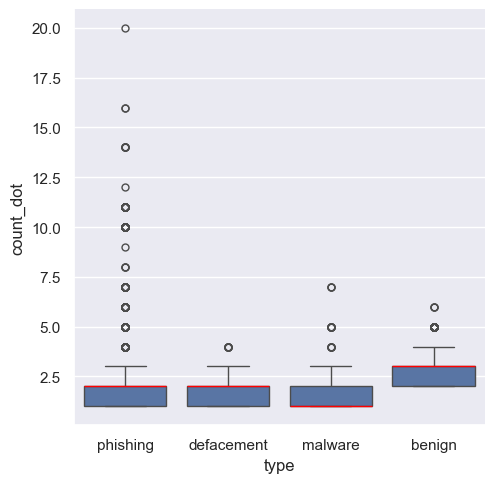

In [35]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dot", kind="box", data=df, medianprops=dict(color="red", linewidth=1))

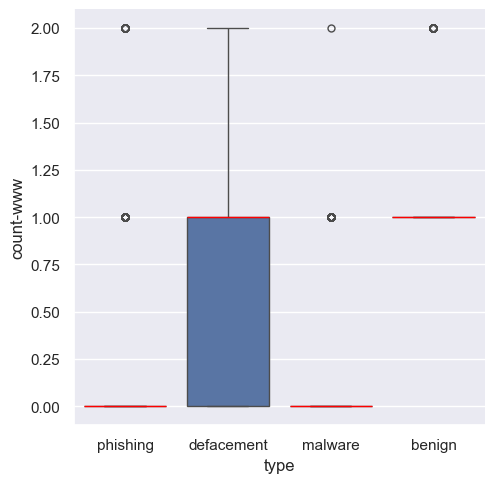

In [36]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df, medianprops=dict(color="red", linewidth=1))

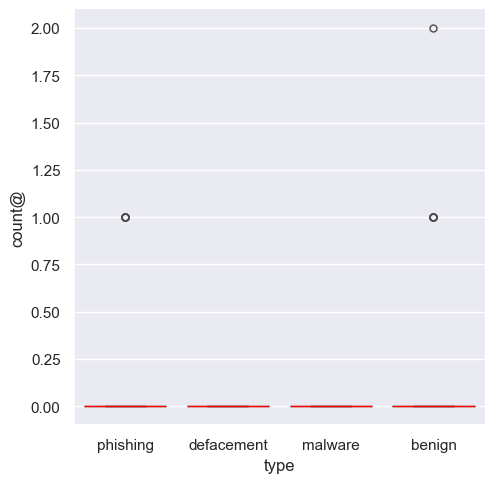

In [37]:
#sns.set(style="darkgrid")
#ax = sns.catplot(x="type", y="count@", kind="box", data=df,medianprops=dict(color="red", linewidth=1))

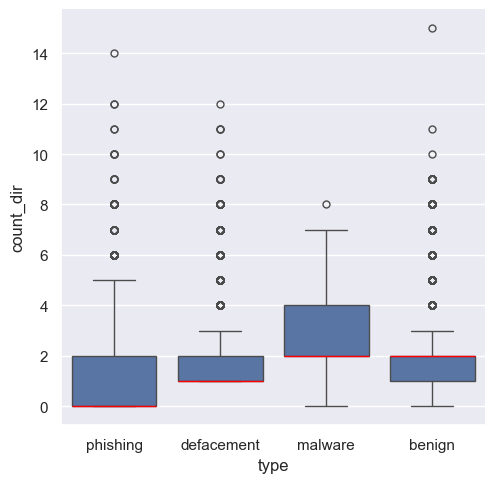

In [38]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df, medianprops=dict(color="red", linewidth=1))

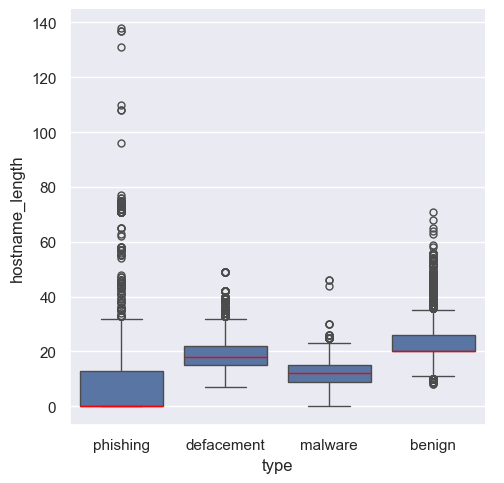

In [34]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df, medianprops=dict(color="red", linewidth=1))

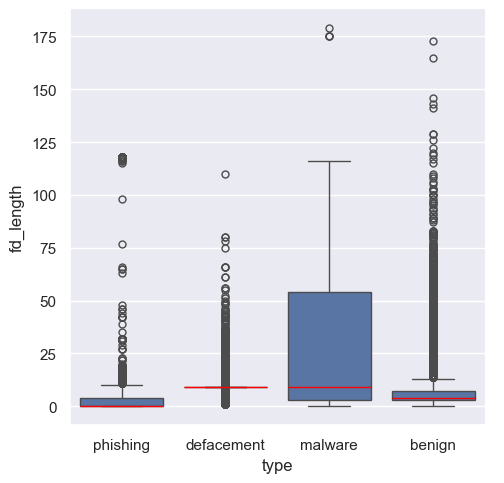

In [39]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df, medianprops=dict(color="red", linewidth=1))

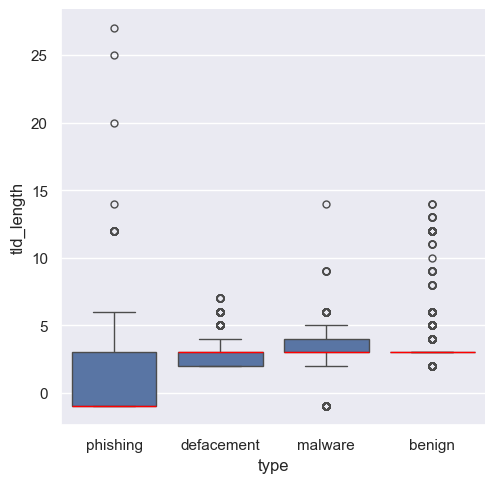

In [40]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df, medianprops=dict(color="red", linewidth=1))

In [41]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

type_code
0    36419
1     9158
3     3002
2     1171
Name: count, dtype: int64

In [42]:
#Predictor Variables
X = df[['use_of_ip','abnormal_url', 'count_dot', 'count-www', 'count@',
       'count_dir', 'count_embed_domain', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [42]:
X.head()

,use_of_ip,abnormal_url,count_dot,count-www,count@,count_dir,count_embed_domain,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,1,0,1,1,0,0,1,...,1,1,4,88,21,0,9,2,7,63
2,0,0,1,0,0,1,1,0,0,1,...,1,1,3,200,23,0,9,3,18,168
3,0,0,2,1,0,1,0,0,0,1,...,0,1,0,44,22,0,14,3,0,37
4,0,0,2,1,0,3,1,0,0,1,...,0,1,0,64,20,0,9,2,4,50


In [43]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count_dot', 'count-www', 'count@',
       'count_dir', 'count_embed_domain', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [45]:
# Logistic Regression Baseline

=== LOGISTIC REGRESSION (Class Weighted) ===
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      7284
  defacement       0.95      0.89      0.92      1832
    phishing       0.43      0.67      0.52       234
     malware       0.88      0.84      0.86       600

    accuracy                           0.96      9950
   macro avg       0.81      0.85      0.82      9950
weighted avg       0.97      0.96      0.97      9950

Accuracy: 0.963


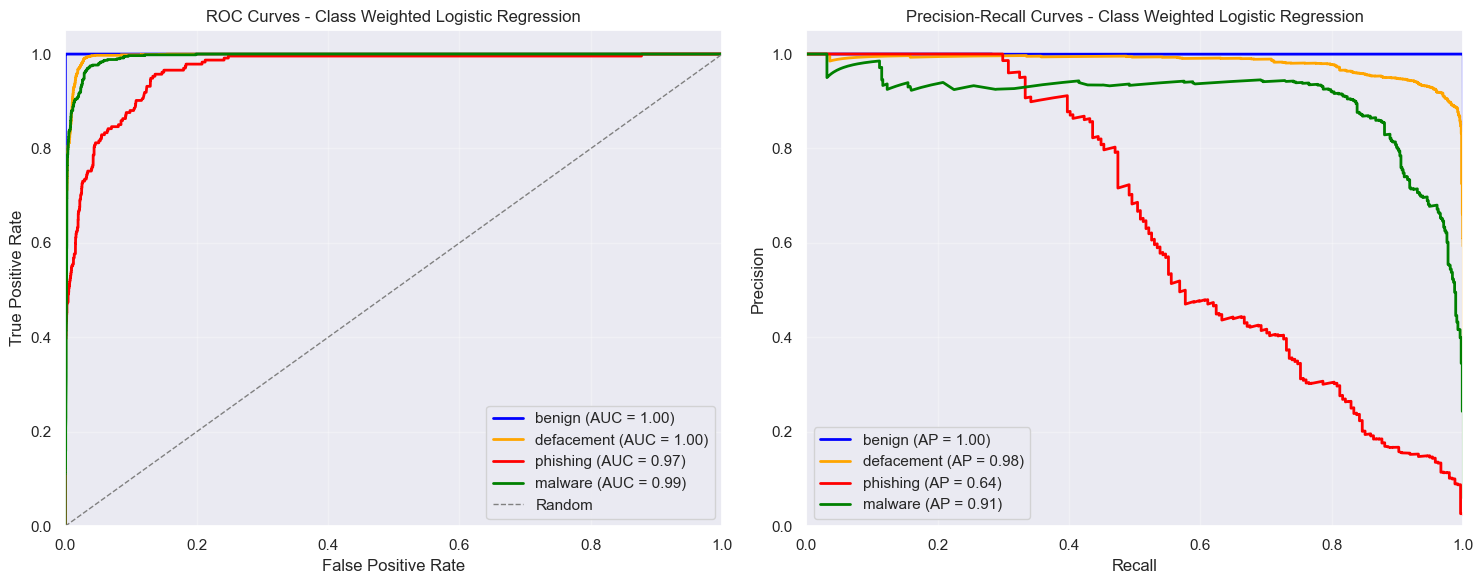


MODEL EVALUATION SUMMARY

ROC-AUC Scores:
        benign: 1.000
    defacement: 0.996
      phishing: 0.967
       malware: 0.994

Average Precision Scores:
        benign: 1.000
    defacement: 0.981
      phishing: 0.643
       malware: 0.906

Macro Average AUC: 0.989
Macro Average AP:  0.883


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Class Weighted Logistic Regression
print("=== LOGISTIC REGRESSION (Class Weighted) ===")
baseline_lr = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

baseline_lr.fit(X_train, y_train)
y_pred_baseline = baseline_lr.predict(X_test)

print(classification_report(y_test, y_pred_baseline, 
                          target_names=['benign', 'defacement','phishing','malware']))
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy: {baseline_accuracy:.3f}")

# === ROC AND PR CURVES ===

# Get prediction probabilities
y_prob = baseline_lr.predict_proba(X_test)
classes = ['benign', 'defacement', 'phishing', 'malware']
n_classes = len(classes)

# Binarise output labels 
y_test_bin = label_binarize(y_test, classes=baseline_lr.classes_)

#subplots for ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# === ROC CURVES ===
colors = ['blue', 'orange', 'red', 'green']
for i, (class_name, color) in enumerate(zip(classes, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - Class Weighted Logistic Regression')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# === PRECISION-RECALL CURVES ===
for i, (class_name, color) in enumerate(zip(classes, colors)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    ax2.plot(recall, precision, color=color, lw=2,
             label=f'{class_name} (AP = {avg_precision:.2f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves - Class Weighted Logistic Regression')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === PRINT SUMMARY SCORES ===
print("\n" + "="*50)
print("MODEL EVALUATION SUMMARY")
print("="*50)

print("\nROC-AUC Scores:")
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {class_name:>12}: {roc_auc:.3f}")

print("\nAverage Precision Scores:")
for i, class_name in enumerate(classes):
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    print(f"  {class_name:>12}: {avg_precision:.3f}")

# Calculate macro averages
macro_auc = np.mean([auc(*roc_curve(y_test_bin[:, i], y_prob[:, i])[:2]) 
                     for i in range(n_classes)])
macro_ap = np.mean([average_precision_score(y_test_bin[:, i], y_prob[:, i]) 
                    for i in range(n_classes)])

print(f"\nMacro Average AUC: {macro_auc:.3f}")
print(f"Macro Average AP:  {macro_ap:.3f}")

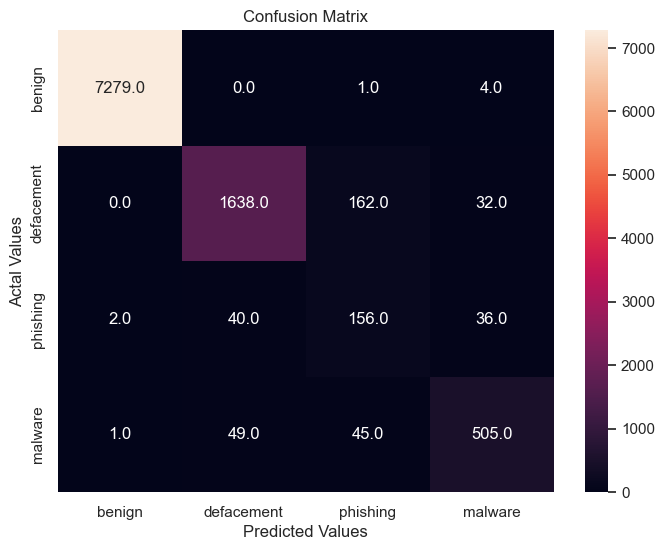

In [47]:
cm = confusion_matrix(y_test, y_pred_baseline)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()  

In [48]:
#Random Forest Model

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      7284
  defacement       0.97      1.00      0.99      1832
    phishing       0.98      0.85      0.91       234
     malware       0.95      0.93      0.94       600

    accuracy                           0.99      9950
   macro avg       0.98      0.94      0.96      9950
weighted avg       0.99      0.99      0.99      9950

accuracy:    0.992


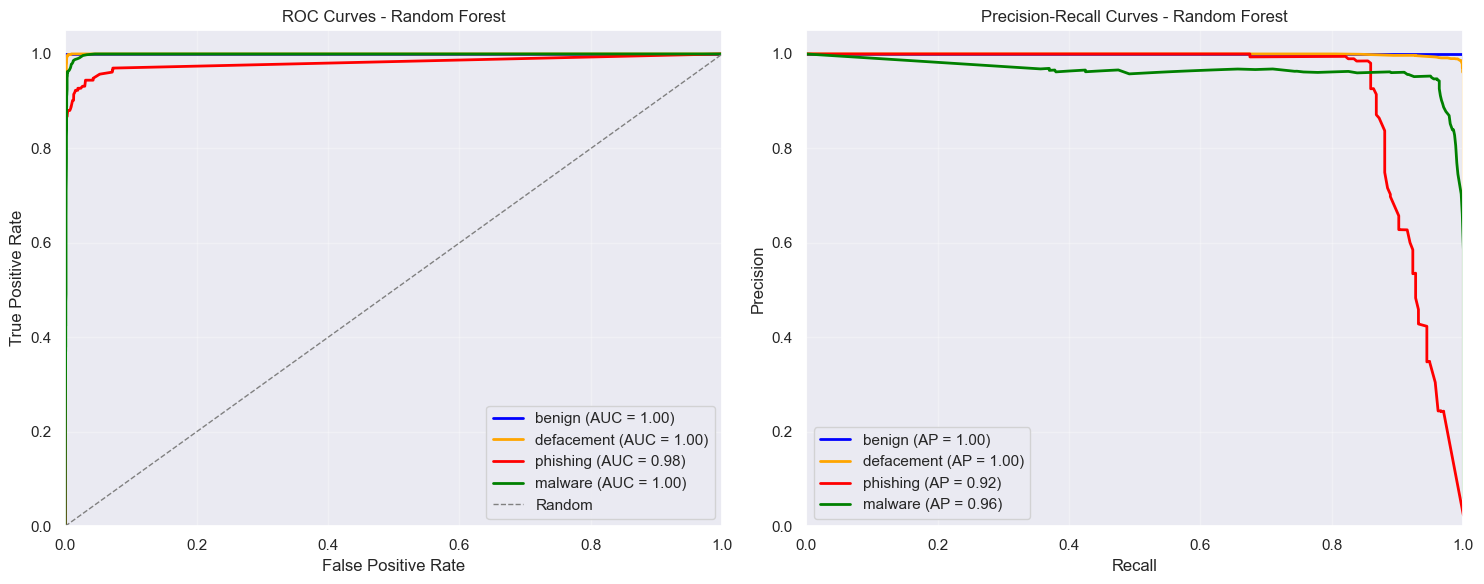


RANDOM FOREST EVALUATION SUMMARY

ROC-AUC Scores:
        benign: 1.000
    defacement: 1.000
      phishing: 0.981
       malware: 0.998

Average Precision Scores:
        benign: 1.000
    defacement: 0.999
      phishing: 0.922
       malware: 0.959

Macro Average AUC: 0.995
Macro Average AP:  0.970


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

rf = RandomForestClassifier(n_estimators=70, max_features='sqrt', class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=['benign', 'defacement','phishing','malware']))
score = accuracy_score(y_test, y_pred_rf)
print("accuracy:    %0.3f" % score)

# === ROC AND PR CURVES FOR RANDOM FOREST ===

# Get prediction probabilities
y_prob_rf = rf.predict_proba(X_test)
classes = ['benign', 'defacement', 'phishing', 'malware']
n_classes = len(classes)

# Binarise output labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=rf.classes_)

# Create subplots for ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# === ROC CURVES ===
colors = ['blue', 'orange', 'red', 'green']
for i, (class_name, color) in enumerate(zip(classes, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - Random Forest')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# === PRECISION-RECALL CURVES ===
for i, (class_name, color) in enumerate(zip(classes, colors)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_rf[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob_rf[:, i])
    ax2.plot(recall, precision, color=color, lw=2,
             label=f'{class_name} (AP = {avg_precision:.2f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves - Random Forest')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === PRINT SUMMARY SCORES ===
print("\n" + "="*50)
print("RANDOM FOREST EVALUATION SUMMARY")
print("="*50)

print("\nROC-AUC Scores:")
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_rf[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {class_name:>12}: {roc_auc:.3f}")

print("\nAverage Precision Scores:")
for i, class_name in enumerate(classes):
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob_rf[:, i])
    print(f"  {class_name:>12}: {avg_precision:.3f}")

# Calculate macro averages
macro_auc = np.mean([auc(*roc_curve(y_test_bin[:, i], y_prob_rf[:, i])[:2]) 
                     for i in range(n_classes)])
macro_ap = np.mean([average_precision_score(y_test_bin[:, i], y_prob_rf[:, i]) 
                    for i in range(n_classes)])

print(f"\nMacro Average AUC: {macro_auc:.3f}")
print(f"Macro Average AP:  {macro_ap:.3f}")

In [56]:
print("Sample benign URLs from training:")
benign_samples = df[df['type'] == 'benign']['url'].sample(10)
for url in benign_samples:
    print(url)

Sample benign URLs from training:
https://www.gosonja.com/?p=5850
https://www.en.wikipedia.org/wiki/Category:Companies_established_in_1931
https://www.johnnyrao.com/?q=node/3
https://www.en.wikipedia.org/wiki/Nuns%27_Island_gas_station
https://www.idolator.com/6011622/kelly-clarkson-reveals-stronger-track-listing
https://www.judgepedia.org/index.php/Paul_Plunkett
https://www.grenadine.promodj.com/
https://www.forums.gametrailers.com/thread/wow-like-single-player-rpg-/904073
https://www.en.wikipedia.org/wiki/Thigmotactic_(album)
https://www.en.wikipedia.org/wiki/Ross_Cleveland


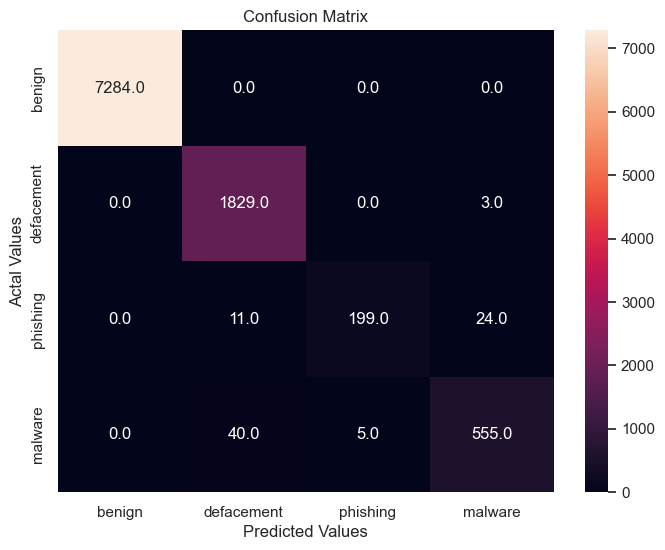

In [57]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()           

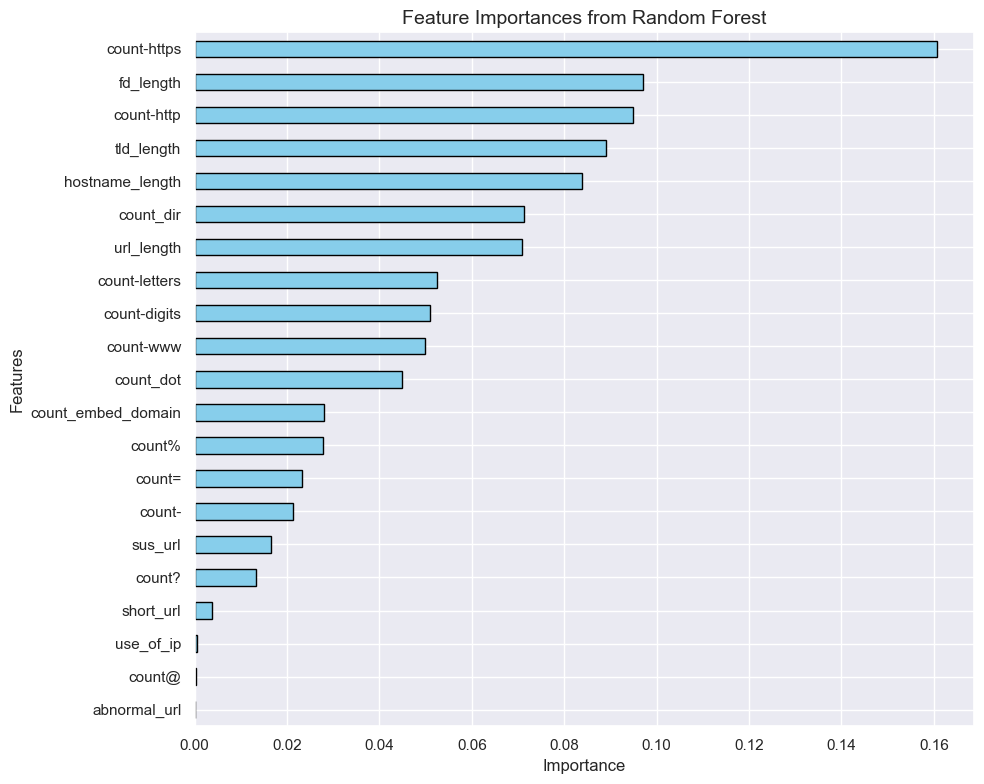

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort in descending order
feat_importances = feat_importances.sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 8))
feat_importances.plot(kind="barh", color="skyblue", edgecolor="black")

plt.title("Feature Importances from Random Forest", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()


In [55]:
import joblib, sys, sklearn

bundle = {
    "model": rf,            
    "label_encoder": lb_make,
    "versions": {"python": sys.version.split()[0], "sklearn": sklearn.__version__}
}
joblib.dump(bundle, "lgbm_bundle.joblib", compress=("xz", 3))
print("Saved to rf_bundle.joblib")


Saved to rf_bundle.joblib


In [58]:
print("Total benign URLs:", len(df[df['type'] == 'benign']))
all_benign = df[df['type'] == 'benign']['url'].sample(50)  # Larger sample
suspicious_patterns = [url for url in all_benign if any(word in url.lower() for word in ['torrent', 'download', 'crack', 'hack'])]
print("Suspicious URLs in benign class:", len(suspicious_patterns))

Total benign URLs: 36419
Suspicious URLs in benign class: 0


In [ ]:
#LGBM Model

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      7284
  defacement       0.99      1.00      0.99      1832
    phishing       0.94      0.88      0.91       234
     malware       0.95      0.95      0.95       600

    accuracy                           0.99      9950
   macro avg       0.97      0.96      0.96      9950
weighted avg       0.99      0.99      0.99      9950

Class Weighted LightGBM accuracy: 0.994


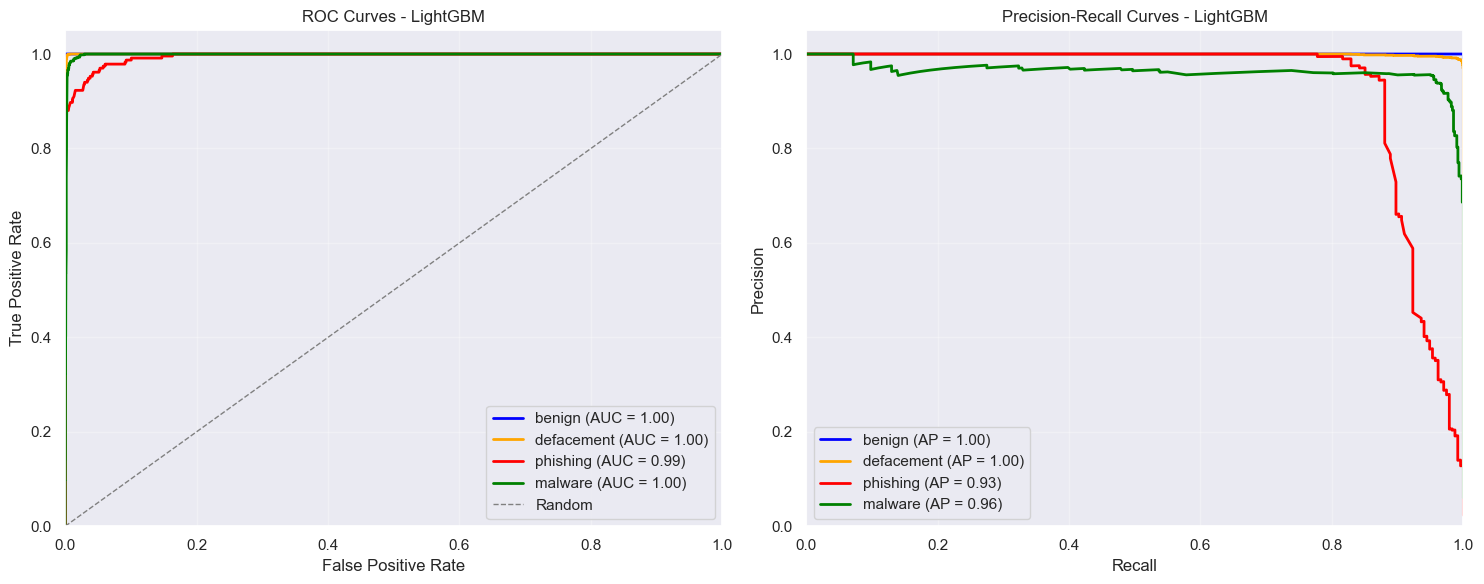


LIGHTGBM EVALUATION SUMMARY

ROC-AUC Scores:
        benign: 1.000
    defacement: 1.000
      phishing: 0.995
       malware: 0.998

Average Precision Scores:
        benign: 1.000
    defacement: 0.999
      phishing: 0.931
       malware: 0.963

Macro Average AUC: 0.998
Macro Average AP:  0.973


In [60]:
from sklearn.metrics import classification_report, accuracy_score
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5, 
          verbosity=-1, random_state=5, num_leaves=31, class_weight='balanced')
LGB_C = lgb.fit(X_train, y_train)
y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))
score = metrics.accuracy_score(y_test, y_pred_lgb)
print("Class Weighted LightGBM accuracy: %0.3f" % score)


# === ROC AND PR CURVES FOR LIGHTGBM ===

# Get prediction probabilities
y_prob_lgb = LGB_C.predict_proba(X_test)
classes = ['benign', 'defacement', 'phishing', 'malware']
n_classes = len(classes)

# Binarise the output labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=LGB_C.classes_)

# Create subplots for ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# === ROC CURVES ===
colors = ['blue', 'orange', 'red', 'green']
for i, (class_name, color) in enumerate(zip(classes, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_lgb[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - LightGBM')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# === PRECISION-RECALL CURVES ===
for i, (class_name, color) in enumerate(zip(classes, colors)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_lgb[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob_lgb[:, i])
    ax2.plot(recall, precision, color=color, lw=2,
             label=f'{class_name} (AP = {avg_precision:.2f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves - LightGBM')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === PRINT SUMMARY SCORES ===
print("\n" + "="*50)
print("LIGHTGBM EVALUATION SUMMARY")
print("="*50)

print("\nROC-AUC Scores:")
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_lgb[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {class_name:>12}: {roc_auc:.3f}")

print("\nAverage Precision Scores:")
for i, class_name in enumerate(classes):
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob_lgb[:, i])
    print(f"  {class_name:>12}: {avg_precision:.3f}")

# Calculate macro averages
macro_auc = np.mean([auc(*roc_curve(y_test_bin[:, i], y_prob_lgb[:, i])[:2]) 
                     for i in range(n_classes)])
macro_ap = np.mean([average_precision_score(y_test_bin[:, i], y_prob_lgb[:, i]) 
                    for i in range(n_classes)])

print(f"\nMacro Average AUC: {macro_auc:.3f}")
print(f"Macro Average AP:  {macro_ap:.3f}")

In [61]:
import joblib, sys, sklearn

bundle = {
    "model": lgb,            # LightGBM model
    "label_encoder": lb_make,
    "versions": {"python": sys.version.split()[0], "sklearn": sklearn.__version__}
}
joblib.dump(bundle, "lgbm_bundle.joblib", compress=("xz", 3))
print("Saved to lgbm_bundle.joblib")


Saved to lgbm_bundle.joblib


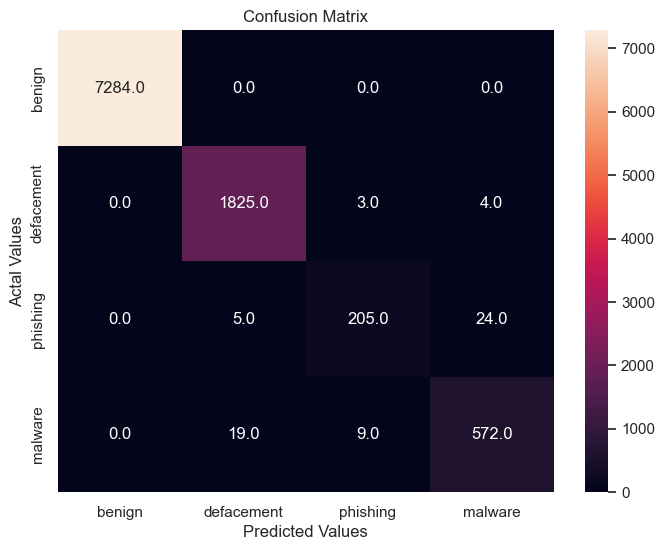

In [62]:
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

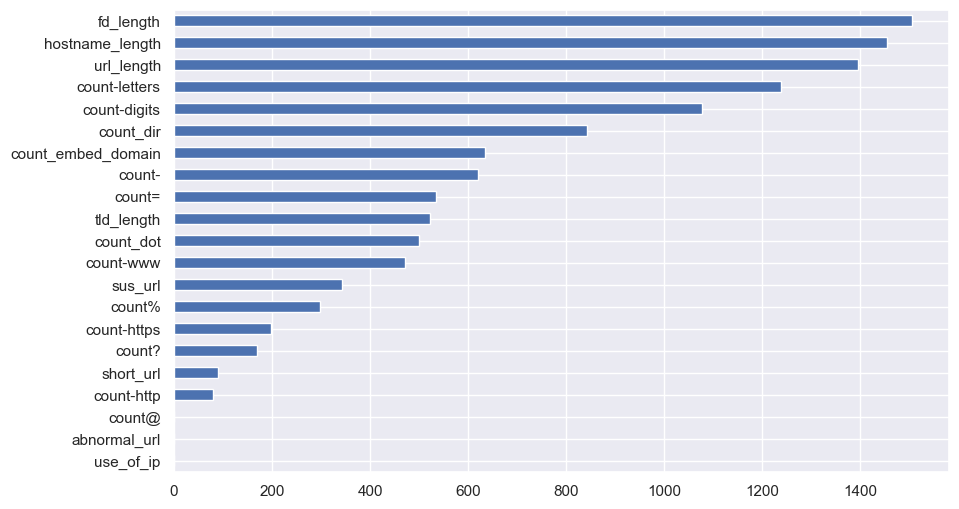

In [63]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [63]:
#XGBOOST MODEL


=== XGBoost: Sample Weighted Implementation ===
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      7284
  defacement       0.99      0.99      0.99      1832
    phishing       0.93      0.87      0.90       234
     malware       0.95      0.95      0.95       600

    accuracy                           0.99      9950
   macro avg       0.97      0.96      0.96      9950
weighted avg       0.99      0.99      0.99      9950

Sample Weighted XGBoost accuracy: 0.993


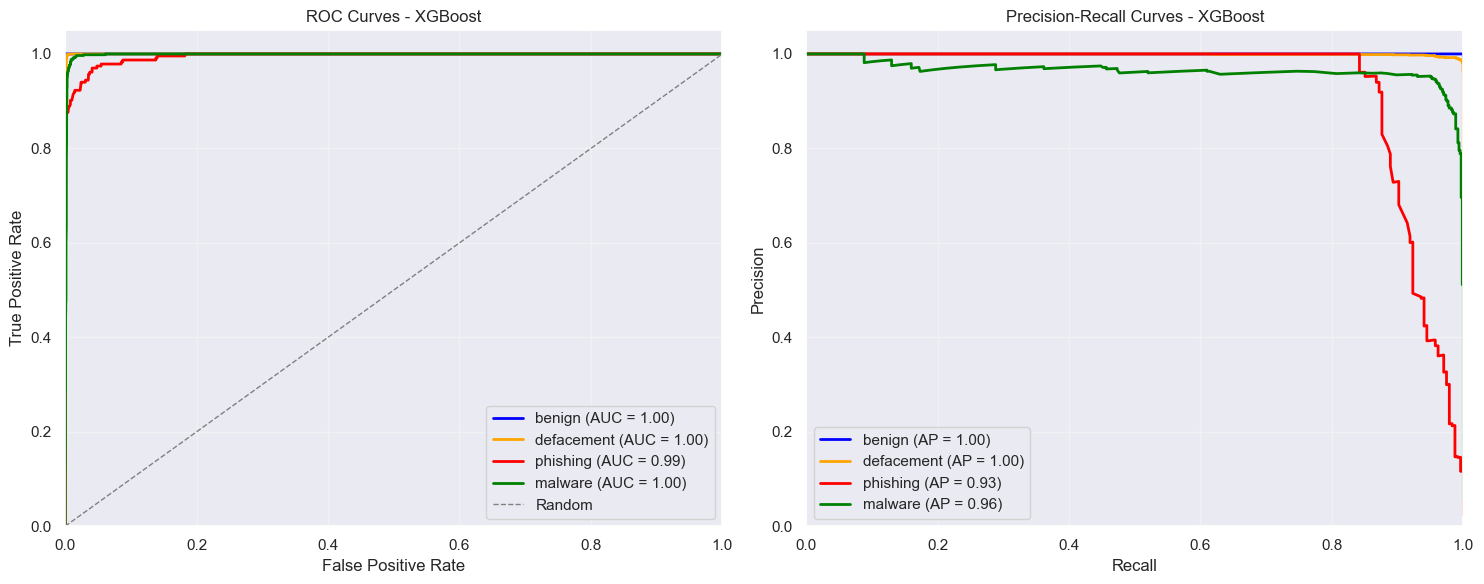


XGBOOST EVALUATION SUMMARY

ROC-AUC Scores:
        benign: 1.000
    defacement: 1.000
      phishing: 0.995
       malware: 0.998

Average Precision Scores:
        benign: 1.000
    defacement: 0.999
      phishing: 0.934
       malware: 0.965

Macro Average AUC: 0.998
Macro Average AP:  0.974


In [65]:
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

print("\n=== XGBoost: Sample Weighted Implementation ===")
# Calculate class weights for imbalanced data
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)

# Create sample weights based on class weights
sample_weights = np.ones(len(y_train))
for i, class_val in enumerate(classes):
    mask = (y_train == class_val)
    sample_weights[mask] = class_weights[i]

# Create the XGBoost model
xgb_weighted = xgb.XGBClassifier(n_estimators=100, random_state=42)
# Fit with sample weights
xgb_weighted.fit(X_train, y_train, sample_weight=sample_weights)
# Make predictions
y_pred_xgb_weighted = xgb_weighted.predict(X_test)

# Print results
print(classification_report(y_test, y_pred_xgb_weighted, target_names=['benign', 'defacement','phishing','malware']))
score_weighted = accuracy_score(y_test, y_pred_xgb_weighted)
print("Sample Weighted XGBoost accuracy: %0.3f" % score_weighted)


# === ADD ROC AND PR CURVES FOR XGBOOST ===

# Get prediction probabilities
y_prob_xgb = xgb_weighted.predict_proba(X_test)
class_names = ['benign', 'defacement', 'phishing', 'malware']
n_classes = len(class_names)

# Binarise the output labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=xgb_weighted.classes_)

#subplots for ROC and PR curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# === ROC CURVES ===
colors = ['blue', 'orange', 'red', 'green']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color=color, lw=2,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - XGBoost')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# === PRECISION-RECALL CURVES ===
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_xgb[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob_xgb[:, i])
    ax2.plot(recall, precision, color=color, lw=2,
             label=f'{class_name} (AP = {avg_precision:.2f})')

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves - XGBoost')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === PRINT SUMMARY SCORES ===
print("\n" + "="*50)
print("XGBOOST EVALUATION SUMMARY")
print("="*50)

print("\nROC-AUC Scores:")
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob_xgb[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"  {class_name:>12}: {roc_auc:.3f}")

print("\nAverage Precision Scores:")
for i, class_name in enumerate(class_names):
    avg_precision = average_precision_score(y_test_bin[:, i], y_prob_xgb[:, i])
    print(f"  {class_name:>12}: {avg_precision:.3f}")

# Calculate macro averages
macro_auc = np.mean([auc(*roc_curve(y_test_bin[:, i], y_prob_xgb[:, i])[:2]) 
                     for i in range(n_classes)])
macro_ap = np.mean([average_precision_score(y_test_bin[:, i], y_prob_xgb[:, i]) 
                    for i in range(n_classes)])

print(f"\nMacro Average AUC: {macro_auc:.3f}")
print(f"Macro Average AP:  {macro_ap:.3f}")

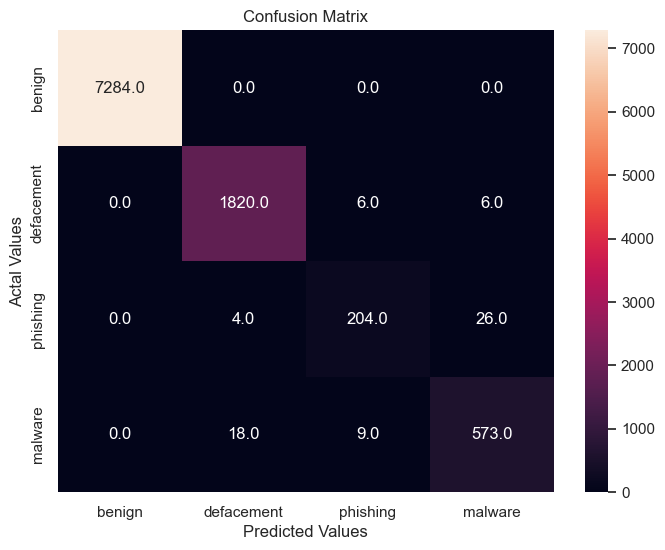

In [66]:
cm = confusion_matrix(y_test, y_pred_xgb_weighted)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'], 
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

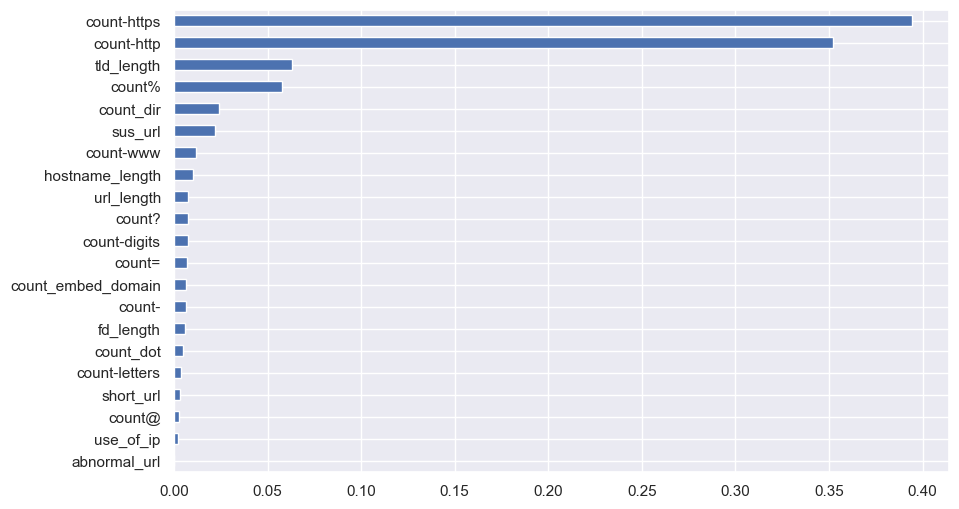

In [67]:
feat_importances = pd.Series(xgb_weighted.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [69]:
print(X.columns.tolist())

['use_of_ip', 'abnormal_url', 'count_dot', 'count-www', 'count@', 'count_dir', 'count_embed_domain', 'short_url', 'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length', 'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits', 'count-letters']


In [70]:
def main(url):
    status = []
    
    status.append(having_ip_address(url))      # use_of_ip
    status.append(abnormal_url(url))           # abnormal_url
    status.append(count_dot(url))              # count_dot
    status.append(count_www(url))              # count-www
    status.append(count_atrate(url))           # count@
    status.append(no_of_dir(url))              # count_dir
    status.append(no_of_embed(url))            # count_embed_domain
    status.append(shortening_service(url))     # short_url
    status.append(count_https(url))            # count-https
    status.append(count_http(url))             # count-http
    status.append(count_per(url))              # count%
    status.append(count_ques(url))             # count?
    status.append(count_hyphen(url))           # count-
    status.append(count_equal(url))            # count=
    status.append(url_length(url))             # url_length
    status.append(hostname_length(url))        # hostname_length
    status.append(suspicious_words(url))       # sus_url
    status.append(fd_length(url))              # fd_length
    status.append(tld_length(url))             # tld_length
    status.append(digit_count(url))            # count-digits
    status.append(letter_count(url))           # count-letters

    return status


feat = main("https://www.pbloftsandextensions.co.uk/")
print(len(feat))           # should be 21
print(feat)                # sanity-look at last four positions



21
[0, 0, 3, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 39, 30, 0, 0, 5, 0, 32]


In [71]:

def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    

    #pred = rf.predict(features_test)
    pred = lgb.predict(features_test)
    #pred = xgb_c.predict(features_test)
    if int(pred[0]) == 0:
        
        res="BENIGN"
        return res
    elif int(pred[0]) == 1.0:
        
        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res
        
    elif int(pred[0]) == 3.0:
        
        res="MALWARE"
        return res

In [72]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')


In [73]:
urls = [
    'https://secure-paypal.com.login.verify.account-update.ru/',
    'https://www.atlantisspace.co.uk'
   
]
for url in urls:
     print(get_prediction_from_url(url))

MALWARE
BENIGN


In [74]:
# Check your model's classes
print("Model classes:", rf.classes_)
print("Number of classes:", len(rf.classes_))

Model classes: [0 1 2 3]
Number of classes: 4


In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

# max_features values 
max_features_options = ['sqrt', 'log2']
#  range for n_estimators 
n_estimators_range = range(10,100,20)

print("Running Random Forest parameter optimisation...")
print("=" * 60)

# Dictionary to store all results for plotting
all_results = {}
# Dictionary to store the best single result for each max_feat
best_results = {}


for max_feat in max_features_options:  # Loop through each max_features setting
    print(f"\nTesting max_features = {max_feat}")
    print("-" * 40)

    # Lists to store n_estimators and accuracy for plotting this max_feat
    n_estimators_for_plot = []
    accuracies_for_plot = []

    best_accuracy_for_this_max_feat = 0
    best_n_estimators_for_this_max_feat = 0

    # Loop through n_estimators range
    for n_est in n_estimators_range:
        # Create Random Forest with current parameters + CLASS WEIGHTING
        rf = RandomForestClassifier(
            n_estimators=n_est, 
            max_features=max_feat,
            class_weight='balanced' 
        )
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)

        # Calculate accuracy
        score = metrics.accuracy_score(y_test, y_pred_rf)

        # Store results for plotting
        n_estimators_for_plot.append(n_est)
        accuracies_for_plot.append(score)

        # Print results
        print(f"n_estimators={n_est:3d}: accuracy = {score:.4f}")

        # Track best accuracy for this max_features setting
        if score > best_accuracy_for_this_max_feat:
            best_accuracy_for_this_max_feat = score
            best_n_estimators_for_this_max_feat = n_est

    # Store all results for plotting
    all_results[max_feat] = {'n_estimators': n_estimators_for_plot, 'accuracies': accuracies_for_plot}
    # Store best results for this max_features
    best_results[max_feat] = {
        'best_n_estimators': best_n_estimators_for_this_max_feat,
        'best_accuracy': best_accuracy_for_this_max_feat
    }

    print(f"Best for max_features={max_feat}: n_estimators={best_n_estimators_for_this_max_feat}, accuracy={best_accuracy_for_this_max_feat:.4f}")

# Find overall best combination
print("\n" + "=" * 60)
print("SUMMARY OF BEST RESULTS")
print("=" * 60)

overall_best_accuracy = 0
overall_best_max_feat = None
overall_best_n_estimators = 0

for max_feat, results in best_results.items():
    print(f"max_features={max_feat}: best n_estimators={results['best_n_estimators']}, best accuracy={results['best_accuracy']:.4f}")

    if results['best_accuracy'] > overall_best_accuracy:
        overall_best_accuracy = results['best_accuracy']
        overall_best_max_feat = max_feat
        overall_best_n_estimators = results['best_n_estimators']

print(f"\nOVERALL BEST COMBINATION:")
print(f"max_features: {overall_best_max_feat}")
print(f"n_estimators: {overall_best_n_estimators}")
print(f"accuracy: {overall_best_accuracy:.4f}")

# Train final model with best parameters and show detailed report
print(f"\nDetailed results for best model:")
print("=" * 60)

# ALSO ADD CLASS WEIGHTING HERE
rf_best = RandomForestClassifier(
    n_estimators=overall_best_n_estimators, 
    max_features=overall_best_max_feat,
    class_weight='balanced'  # <-- AND HERE TOO
)
rf_best.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_test)

print(classification_report(y_test, y_pred_rf_best, target_names=['benign', 'defacement','phishing','malware']))
score_best = metrics.accuracy_score(y_test, y_pred_rf_best)
print("accuracy:   %0.3f" % score_best)

Running Random Forest parameter optimisation...

Testing max_features = sqrt
----------------------------------------


NameError: name 'X_train' is not defined